In [2]:
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [1]:
ARRIVAL = 1/5.0
SERVICE = 10.0  # average service time per server
SIM_TIME = 100000
TYPE1 = 1
SEED = 42

In [3]:
class Measure:
    def __init__(self):
        self.arr = 0
        self.dep = 0
        self.ut = 0
        self.oldT = 0
        self.delay = 0
        self.bs1 = 0  # busy time of server 1
        self.bs2 = 0  # busy time of server 2
        self.loss = 0  # packet loss count

In [4]:
class Client:
    def __init__(self, type, arrival_time):
        self.type = type
        self.arrival_time = arrival_time

In [5]:
def simulate(buffer_size):
    global users, data, MM1, busy1, busy2
    users = 0
    data = Measure()
    MM1 = []
    time = 0
    busy1 = False
    busy2 = False

    FES = PriorityQueue()
    random.seed(SEED)

    def arrival(current_time):
        global users, busy1, busy2
        data.arr += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        inter_arrival = random.expovariate(1.0 / ARRIVAL)
        FES.put((current_time + inter_arrival, "arrival"))

        if users < buffer_size:
            users += 1
            client = Client(TYPE1, current_time)
            MM1.append(client)

            if not busy1:
                service_time = random.expovariate(1.0 / SERVICE)
                data.bs1 += service_time
                FES.put((current_time + service_time, "departure1"))
                busy1 = True
            elif not busy2:
                service_time = random.expovariate(1.0 / SERVICE)
                data.bs2 += service_time
                FES.put((current_time + service_time, "departure2"))
                busy2 = True
        else:
            data.loss += 1

    def departure(current_time, server_id):
        global users, busy1, busy2
        if len(MM1) == 0:
            if server_id == 1:
                busy1 = False
            else:
                busy2 = False
            return

        data.dep += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        client = MM1.pop(0)
        data.delay += (current_time - client.arrival_time)
        users -= 1

        if users > 0:
            service_time = random.expovariate(1.0 / SERVICE)
            if server_id == 1:
                data.bs1 += service_time
                FES.put((current_time + service_time, "departure1"))
            else:
                data.bs2 += service_time
                FES.put((current_time + service_time, "departure2"))
        else:
            if server_id == 1:
                busy1 = False
            else:
                busy2 = False

    FES.put((0, "arrival"))
    while time < SIM_TIME:
        (time, event_type) = FES.get()
        if event_type == "arrival":
            arrival(time)
        elif event_type == "departure1":
            departure(time, 1)
        elif event_type == "departure2":
            departure(time, 2)

    delay = data.delay / data.dep if data.dep > 0 else 0
    avg_users = data.ut / time
    utilization = (data.bs1 + data.bs2) / (time * 2)
    loss_rate = data.loss / data.arr if data.arr > 0 else 0

    return delay, avg_users, utilization, loss_rate

# Run comparison for different buffer sizes vs infinite buffer
buffer_sizes = [2, 4, 6, 8, 10, 20, 50, 100]
finite_results = []
infinite_result = simulate(1000)  # large enough to act as infinite buffer

for size in buffer_sizes:
    res = simulate(size)
    diff = tuple(np.array(res) - np.array(infinite_result))
    finite_results.append((size,) + res + diff)


In [6]:
sizes, delays, users, utils, losses, d_diff, u_diff, util_diff, loss_diff = zip(*finite_results)


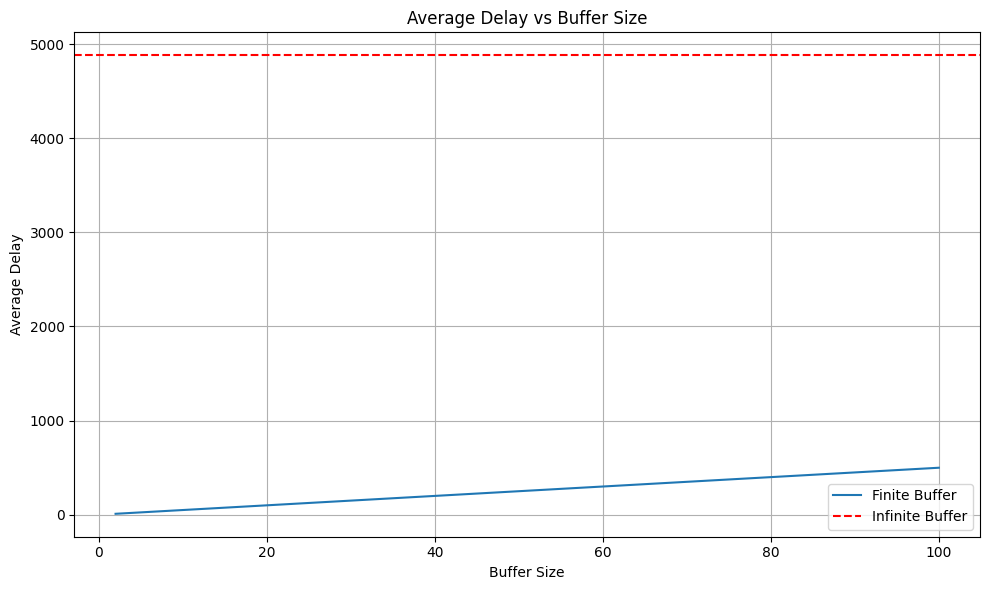

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, delays, label='Finite Buffer')
plt.axhline(infinite_result[0], linestyle='--', color='r', label='Infinite Buffer')
plt.title('Average Delay vs Buffer Size')
plt.xlabel('Buffer Size')
plt.ylabel('Average Delay')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


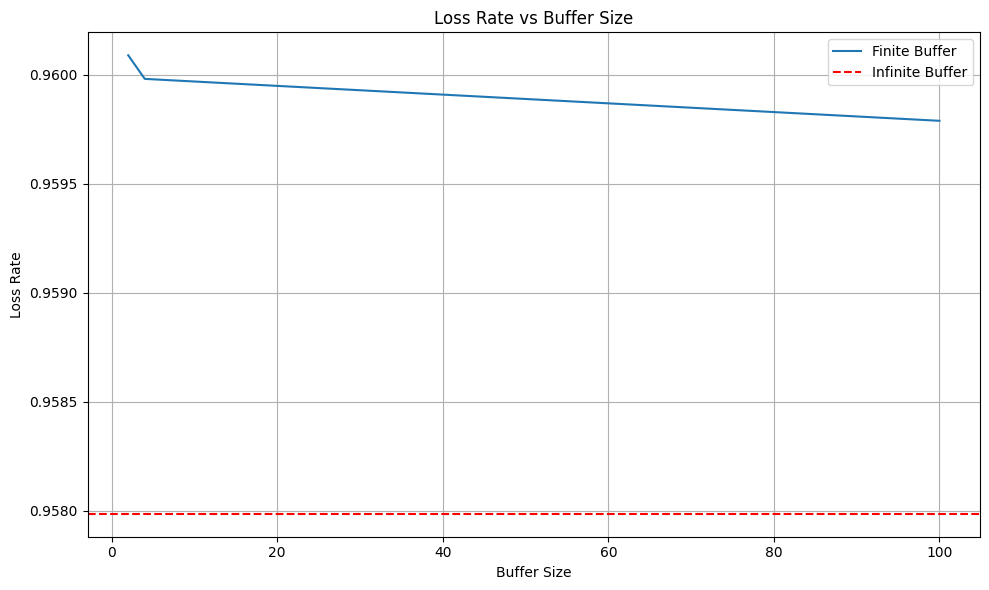

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, losses, label='Finite Buffer')
plt.axhline(infinite_result[3], linestyle='--', color='r', label='Infinite Buffer')
plt.title('Loss Rate vs Buffer Size')
plt.xlabel('Buffer Size')
plt.ylabel('Loss Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

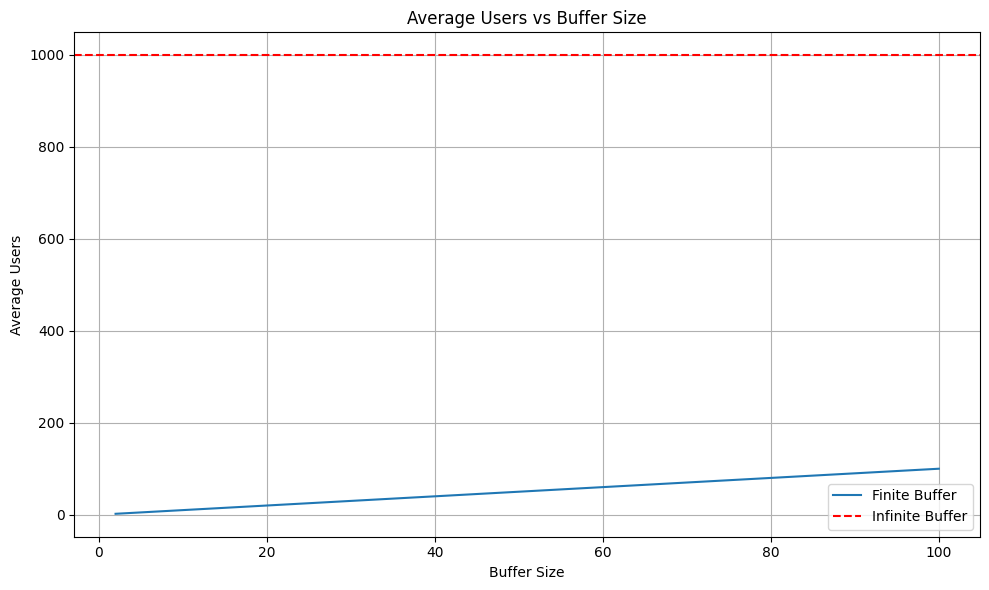

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, users, label='Finite Buffer')
plt.axhline(infinite_result[1], linestyle='--', color='r', label='Infinite Buffer')
plt.title('Average Users vs Buffer Size')
plt.xlabel('Buffer Size')
plt.ylabel('Average Users')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

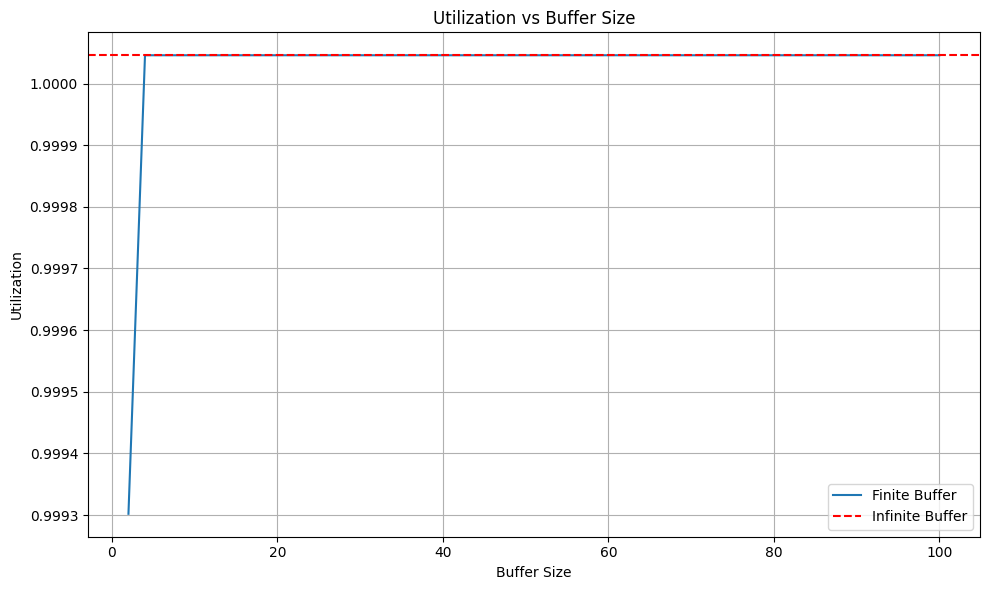

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, utils, label='Finite Buffer')
plt.axhline(infinite_result[2], linestyle='--', color='r', label='Infinite Buffer')
plt.title('Utilization vs Buffer Size')
plt.xlabel('Buffer Size')
plt.ylabel('Utilization')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()